### Importing Libraries

In [1]:
from six.moves import cPickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

### Unpickling data

In [2]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo,encoding="latin1")
        data = dict["data"]
        labels = dict['labels']
    return data,labels

### Reading data

In [3]:
data1,labels1 = unpickle("./Dataset/cifar-10-batches-py/data_batch_1")
data2,labels2 = unpickle("./Dataset/cifar-10-batches-py/data_batch_2")
data3,labels3 = unpickle("./Dataset/cifar-10-batches-py/data_batch_3")
data4,labels4 = unpickle("./Dataset/cifar-10-batches-py/data_batch_4")
data5,labels5 = unpickle("./Dataset/cifar-10-batches-py/data_batch_5")

### One-hot coding

In [4]:
def get_labels(y):
    labels = np.zeros((len(y), 10))
    for idx, val in enumerate(y):
        labels[idx][val] = 1
    return labels

### Stack inputs

In [5]:
# X_tr = np.concatenate([data1, data2, data3, data4, data5], axis=0)
X_tr = np.concatenate([data1], axis=0)
X_tr = np.dstack((X_tr[:, :1024], X_tr[:, 1024:2048], X_tr[:, 2048:])) / 1.0
X_tr = (X_tr - 128) / 255.0
X_tr = X_tr.reshape(-1, 32, 32, 3)

# y_tr = np.concatenate([labels1, labels2, labels3, labels4, labels5], axis=0)
y_tr = np.concatenate([labels1], axis=0)
y_tr = get_labels(y_tr)

print("X_tr", X_tr.shape)
print("y_tr", y_tr.shape)

X_tr (10000, 32, 32, 3)
y_tr (10000, 10)


### Splitting data and target

In [7]:
x_train, x_test, y_train, y_test = train_test_split(X_tr, y_tr, test_size=0.33, random_state=42)

### Augmentation operations

In [8]:
X = tf.placeholder(tf.float32, shape = (32,32,3))
rotated = tf.image.rot90(X)
resize = tf.image.resize_images(X,(16,16),tf.image.ResizeMethod.NEAREST_NEIGHBOR)

### Perform Augmentations

In [9]:
rotated_images, resized_images = [],[]
with tf.Session() as sess:
    for image in X_tr[:4]:
        rot_img,res_img = sess.run([rotated,resize],feed_dict={X:image})
        rotated_images.append(rot_img)
        resized_images.append(res_img)

### Plotting sample augmentations

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

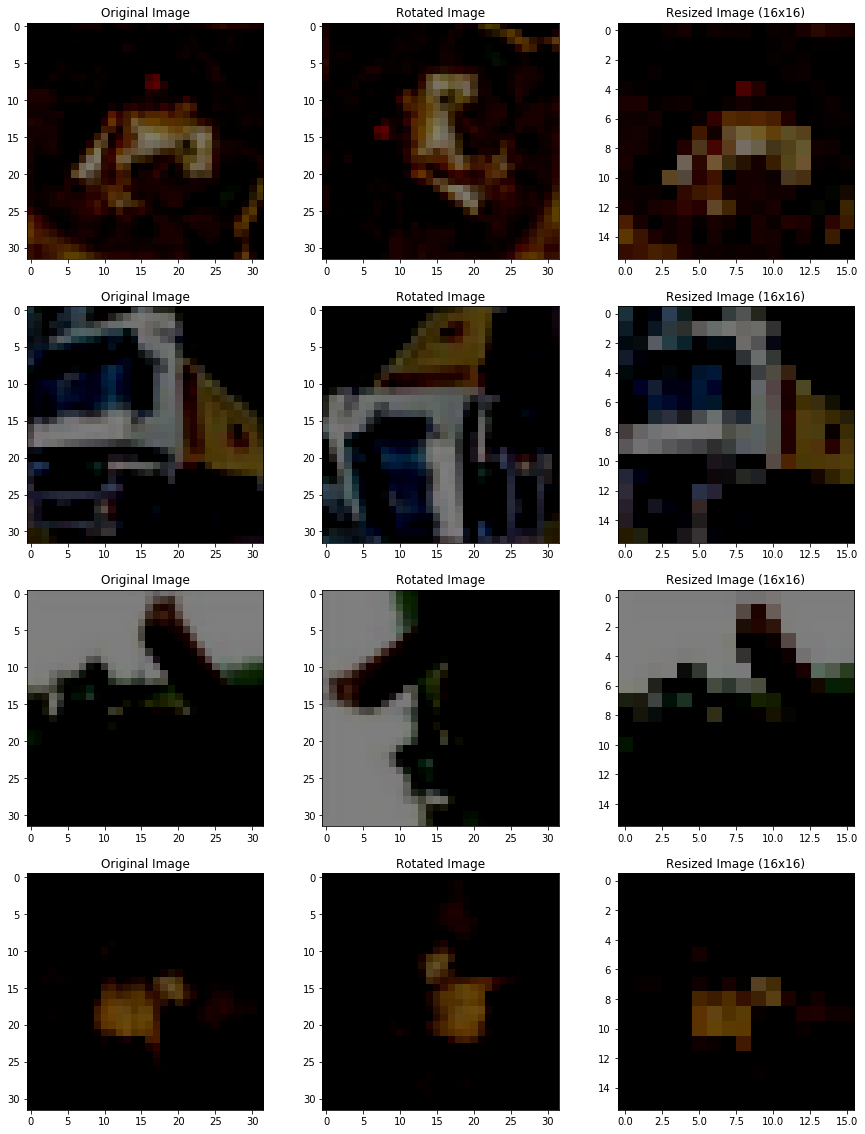

In [22]:
fig, ax = plt.subplots(4,3,figsize=(15,20))
for i in range(4):
    ax[i][0].imshow(X_tr[i])
    ax[i][0].set_title("Original Image")
    ax[i][1].imshow(rotated_images[i])
    ax[i][1].set_title("Rotated Image")
    ax[i][2].imshow(resized_images[i])
    ax[i][2].set_title("Resized Image (16x16)")
plt.show()

### Defining Networks

In [10]:
def conv2d(x,weight,bias):
    x = tf.nn.conv2d(x,weight,strides=[1,1,1,1],padding="SAME")
    x = tf.nn.bias_add(x,bias)
    x = tf.nn.relu(x)
    return x

def maxpool2d(x):
    x = tf.layers.max_pooling2d(x,pool_size=2,strides=2,padding="SAME")
    return x

def batch_normalize(x):
    x = tf.layers.batch_normalization(x)
    return x

def flatten(x):
    flat = tf.contrib.layers.flatten(x)  
    return flat

def fc_layer(x,num_outputs):
    fc = tf.contrib.layers.fully_connected(inputs=x, num_outputs=num_outputs, activation_fn=tf.nn.relu)
    return fc

def out_layer(x,num_outputs):
    x = tf.contrib.layers.fully_connected(inputs=x, num_outputs=num_outputs, activation_fn=None)
    return x


### Defining Placeholders and variables

In [13]:
tf.reset_default_graph() 
n_class = 10

x = tf.placeholder(tf.float32, shape = (None,32,32,3))
y = tf.placeholder(tf.float32,(None,n_class))

with tf.variable_scope("Weights", reuse=tf.AUTO_REUSE):
    w_conv1 = tf.get_variable('w_c1',shape=(3,3,3,64),initializer=tf.contrib.layers.xavier_initializer(uniform=False))
    w_conv2 = tf.get_variable('w_c2',shape=(3,3,64,128),initializer=tf.contrib.layers.xavier_initializer(uniform=False))
    tf.summary.histogram('w1',w_conv1)
    tf.summary.histogram('w2',w_conv2)
    
with tf.variable_scope("Bias", reuse=tf.AUTO_REUSE):
    b_conv1 = tf.get_variable('B_c1',shape=(64),initializer=tf.contrib.layers.xavier_initializer(uniform=False))
    b_conv2 = tf.get_variable('B_c2',shape=(128),initializer=tf.contrib.layers.xavier_initializer(uniform=False))


### Defining Models for trianing

#### Exercise 1

In [14]:
def CIFAR_CNN(x):
  
    conv1 = conv2d(x,w_conv1,b_conv1)
    conv1_pool = maxpool2d(conv1)
    
    flat = flatten(conv1_pool)
    
    fc1 = fc_layer(flat,128)
    out = out_layer(fc1,10)
    
    return out
  

#### Exercise 2

In [15]:
def CIFAR_CNN1(x):

    conv1 = conv2d(x,w_conv1,b_conv1)
    conv1_pool = maxpool2d(conv1)
    conv1_norm = batch_normalize(conv1_pool)

    conv2 = conv2d(conv1_norm,w_conv2,b_conv2)
    conv2_pool = maxpool2d(conv2)
    conv2_norm = batch_normalize(conv2_pool)

    flat = flatten(conv2_norm)

    fc1 = fc_layer(flat,128)
    fc1 = dropout(fc1,0.7)

    fc2 = fc_layer(fc1,256)
    fc2 = dropout(fc2,0.7)

    out = out_layer(fc2,10)

    return out

### Defining operations and calling the model function

In [16]:
model = CIFAR_CNN(x)

predictions = tf.nn.softmax_cross_entropy_with_logits(logits=model,labels=y)
tf.summary.histogram("predictions", predictions)

loss = tf.reduce_mean(predictions)
tf.summary.scalar("Loss_Scalar",loss)
tf.summary.histogram("loss",loss)

with tf.variable_scope("Adam", reuse=tf.AUTO_REUSE):
    optimizer= tf.train.AdamOptimizer().minimize(loss)

correct_pred = tf.equal(tf.argmax(model, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
tf.summary.scalar("Accuracy",accuracy)
tf.summary.histogram("Accuracy_histogram",accuracy)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



<tf.Tensor 'Accuracy_histogram:0' shape=() dtype=string>

### Training the Model

In [21]:
init = tf.global_variables_initializer()
epochs = 10
batch_size = 600

with tf.Session() as sess:
    train_writer = tf.summary.FileWriter("G:/DA - Hildeshim/DDA Lab/Exercise 7/log/1/train",sess.graph)
    test_writer = tf.summary.FileWriter("G:/DA - Hildeshim/DDA Lab/Exercise 7/log/1/test",sess.graph)
    merge = tf.summary.merge_all()    
    sess.run(init)
    counter = 0
    for ep in range(epochs):
        counter += 1
        for batch in range(len(x_train)//batch_size):
            batch_x = x_train[batch*batch_size:min((batch+1)*batch_size,len(x_train))]
            batch_y = y_train[batch*batch_size:min((batch+1)*batch_size,len(y_train))]
            assert not np.any(np.isnan(batch_x))
            assert not np.any(np.isnan(batch_y))
            feed = {x : batch_x, y : batch_y}
            summary, cost, _ , acc = sess.run([merge, loss, optimizer, accuracy], feed_dict = feed)
        print("\nEpoch: "+str(ep)+"\tTraining loss: "+str(cost)+"\tTraining Accuracy: "+str(acc))
        train_writer.add_summary(summary,counter)
        feed = {x : x_test, y : y_test}
        su, cost, acc = sess.run([merge,loss, accuracy], feed_dict = feed)
        test_writer.add_summary(su,counter)
        print("\t\tTesting loss: "+str(cost)+"\tTesting Accuracy: "+str(acc))


Epoch: 0	Training loss: 2.097859	Training Accuracy: 0.25
		Testing loss: 2.0519538	Testing Accuracy: 0.24030302

Epoch: 1	Training loss: 1.8957454	Training Accuracy: 0.32333332
		Testing loss: 1.850331	Testing Accuracy: 0.31727272

Epoch: 2	Training loss: 1.745494	Training Accuracy: 0.36833334
		Testing loss: 1.7097633	Testing Accuracy: 0.38787878

Epoch: 3	Training loss: 1.6149883	Training Accuracy: 0.42833334
		Testing loss: 1.6119287	Testing Accuracy: 0.42636365

Epoch: 4	Training loss: 1.5115993	Training Accuracy: 0.47
		Testing loss: 1.5525576	Testing Accuracy: 0.44848484

Epoch: 5	Training loss: 1.4199247	Training Accuracy: 0.50166667
		Testing loss: 1.4954827	Testing Accuracy: 0.47060606

Epoch: 6	Training loss: 1.3474095	Training Accuracy: 0.53
		Testing loss: 1.4449866	Testing Accuracy: 0.49333334

Epoch: 7	Training loss: 1.2763654	Training Accuracy: 0.55333334
		Testing loss: 1.414842	Testing Accuracy: 0.50666666

Epoch: 8	Training loss: 1.2089341	Training Accuracy: 0.57
		T